# The SQuAD v1.1 Benchmark

reading comprehension dataset, consisting of questions posed by crowdworkers on a set of Wikipedia articles, where the answer to every question is a segment of text, or span, from the corresponding reading passage, or the question might be unanswerable.

For example, [here](https://rajpurkar.github.io/SQuAD-explorer/explore/1.1/dev/Super_Bowl_50.html?model=r-net+%20(ensemble)%20(Microsoft%20Research%20Asia)&version=1.1) are some interesting examples on the topic of Super Bowl 50.

## BERT Input Format

To feed a QA task into BERT, we pack both the question and the reference text into the input.

![title](images/input_formatting.png)

The two pieces of text are separated by the special **[SEP]** token.

BERT also uses “Segment Embeddings” to differentiate the question from the reference text. These are simply two embeddings **(for segments “A” and “B”)** that BERT learned, and which it adds to the token embeddings before feeding them into the input layer.

## Start & End Token Classifiers
BERT needs to highlight a “span” of text containing the answer–this is represented as simply predicting which token marks the start of the answer, and which token marks the end.

![title](images/start_token_classification.png)

For every token in the text, we feed its final embedding into the start token classifier. The start token classifier only has a single set of weights (represented by the blue **“start”** rectangle in the above illustration) which it applies to every word.

After taking the dot product between the output embeddings and the **‘start’** weights, we apply the softmax activation to produce a probability distribution over all of the words. Whichever word has the highest probability of being the start token is the one that we pick.

**We repeat this process for the end token–we have a separate weight vector**

<img src="images/end_token_classification.png" width="800">


# Load Huggingface Fine-Tuned BERT

For Question Answering we use the **BertForQuestionAnswering** class from the transformers library.
In the example code below, we'll be downloading a model that's already been fine-tuned for question answering, and try it out on our own text.

If you do want to fine-tune on your own dataset, it is possible to fine-tune BERT for question answering yourself. See [**run_squad.py**](https://github.com/huggingface/transformers/blob/master/examples/question-answering/run_squad.py) in the **transformers** library. However,you may find that the below "fine-tuned-on-squad" model already does a good job, even if your text is from a different domain. Huggingface documentation on BERT question answering could be found [**here**](https://huggingface.co/transformers/model_doc/bert.html?highlight=bertforquestionanswering#transformers.BertForQuestionAnswering)

For Question Answering, they have a version of BERT-large that has already been fine-tuned for the SQuAD benchmark.

BERT-large is really big... it has 24-layers and an embedding size of 1,024, for a total of 340M parameters! Altogether it is 1.34GB, so expect it to take a couple minutes to download. 

**Note: I believe this model was trained on version 1 of SQuAD, since it's not outputting whether the question is "impossible" to answer from the text (which is part of the task in v2 of SQuAD).**

In [8]:
import torch

In [1]:
from transformers import BertForQuestionAnswering

model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

Load the tokenizer as well.

Side note: Apparently the vocabulary of this model is identicaly to the one in bert-base-uncased. You can load the tokenizer from bert-base-uncased and that works just as well.

In [2]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

## Ask a Question

In [3]:
question = "How many parameters does BERT-large have?"
answer_text = "BERT-large is really big... it has 24-layers and an embedding size of 1,024, for a total of 340M parameters! Altogether it is 1.34GB, so expect it to take a couple minutes to download to your Colab instance."

We'll need to run the BERT tokenizer against both the **question and the answer_text**. To feed these into BERT, we actually concatenate them together and place the special [SEP] token in between.

In [4]:
# Apply the tokenizer to the input text, treating them as a text-pair.
input_ids = tokenizer.encode(question, answer_text)

print('The input has a total of {:} tokens.'.format(len(input_ids)))

The input has a total of 70 tokens.


Just to see exactly what the tokenizer is doing, let's print out the tokens with their IDs.



In [5]:
# BERT only needs the token IDs, but for the purpose of inspecting the 
# tokenizer's behavior, let's also get the token strings and display them.
tokens = tokenizer.convert_ids_to_tokens(input_ids)

# For each token and its id...
for token, id in zip(tokens, input_ids):
    
    # If this is the [SEP] token, add some space around it to make it stand out.
    if id == tokenizer.sep_token_id:
        print('')
    
    # Print the token string and its ID in two columns.
    print('{:<12} {:>6,}'.format(token, id))

    if id == tokenizer.sep_token_id:
        print('')
    

[CLS]           101
how           2,129
many          2,116
parameters   11,709
does          2,515
bert         14,324
-             1,011
large         2,312
have          2,031
?             1,029

[SEP]           102

bert         14,324
-             1,011
large         2,312
is            2,003
really        2,428
big           2,502
.             1,012
.             1,012
.             1,012
it            2,009
has           2,038
24            2,484
-             1,011
layers        9,014
and           1,998
an            2,019
em            7,861
##bed         8,270
##ding        4,667
size          2,946
of            1,997
1             1,015
,             1,010
02            6,185
##4           2,549
,             1,010
for           2,005
a             1,037
total         2,561
of            1,997
340          16,029
##m           2,213
parameters   11,709
!               999
altogether   10,462
it            2,009
is            2,003
1             1,015
.             1,01

We've concatenated the **question and answer_text** together, but BERT still needs a way to distinguish them. BERT has two special "Segment" embeddings, one for segment "A" and one for segment "B". Before the word embeddings go into the BERT layers, the segment A embedding needs to be added to the **question** tokens, and the segment B embedding needs to be added to each of the answer_text tokens.

These additions are handled for us by the **transformer** library, and all we need to do is specify a '0' or '1' for each token.

**Note: In the transformers library, huggingface likes to call these token_type_ids, but I'm going with segment_ids since this seems clearer, and is consistent with the BERT paper.**

In [6]:
# Search the input_ids for the first instance of the `[SEP]` token.
sep_index = input_ids.index(tokenizer.sep_token_id)

# The number of segment A tokens includes the [SEP] token istelf.
num_seg_a = sep_index + 1

# The remainder are segment B.
num_seg_b = len(input_ids) - num_seg_a

# Construct the list of 0s and 1s.
segment_ids = [0]*num_seg_a + [1]*num_seg_b

# There should be a segment_id for every input token.
assert len(segment_ids) == len(input_ids)

**Side Note: Where's the padding?**

The original example code does not perform any padding. I suspect that this is because we are only feeding in a single example. If we instead fed in a batch of examples, then we would need to pad or truncate all of the samples in the batch to a single length, and supply an attention mask to tell BERT to ignore the padding tokens.

In [9]:
# Run our example through the model.
start_scores, end_scores = model(torch.tensor([input_ids]), # The tokens representing our input text.
                                 token_type_ids=torch.tensor([segment_ids])) # The segment IDs to differentiate question from answer_text


Now we can highlight the answer just by looking at the most probable start and end words.



In [10]:
# Find the tokens with the highest `start` and `end` scores.
answer_start = torch.argmax(start_scores)
answer_end = torch.argmax(end_scores)

# Combine the tokens in the answer and print it out.
answer = ' '.join(tokens[answer_start:answer_end+1])

print('Answer: "' + answer + '"')

Answer: "340 ##m"


With a little more effort, we can reconstruct any words that got broken down into subwords.



In [11]:
# Start with the first token.
answer = tokens[answer_start]

# Select the remaining answer tokens and join them with whitespace.
for i in range(answer_start + 1, answer_end + 1):
    
    # If it's a subword token, then recombine it with the previous token.
    if tokens[i][0:2] == '##':
        answer += tokens[i][2:]
    
    # Otherwise, add a space then the token.
    else:
        answer += ' ' + tokens[i]

print('Answer: "' + answer + '"')

Answer: "340m"


## Turn the QA process into a function so we can easily try out other examples.



In [12]:
def answer_question(question, answer_text):
    '''
    Takes a `question` string and an `answer_text` string (which contains the
    answer), and identifies the words within the `answer_text` that are the
    answer. Prints them out.
    '''
    # ======== Tokenize ========
    # Apply the tokenizer to the input text, treating them as a text-pair.
    input_ids = tokenizer.encode(question, answer_text)

    # Report how long the input sequence is.
    print('Query has {:,} tokens.\n'.format(len(input_ids)))

    # ======== Set Segment IDs ========
    # Search the input_ids for the first instance of the `[SEP]` token.
    sep_index = input_ids.index(tokenizer.sep_token_id)

    # The number of segment A tokens includes the [SEP] token istelf.
    num_seg_a = sep_index + 1

    # The remainder are segment B.
    num_seg_b = len(input_ids) - num_seg_a

    # Construct the list of 0s and 1s.
    segment_ids = [0]*num_seg_a + [1]*num_seg_b

    # There should be a segment_id for every input token.
    assert len(segment_ids) == len(input_ids)

    # ======== Evaluate ========
    # Run our example question through the model.
    start_scores, end_scores = model(torch.tensor([input_ids]), # The tokens representing our input text.
                                    token_type_ids=torch.tensor([segment_ids])) # The segment IDs to differentiate question from answer_text

    # ======== Reconstruct Answer ========
    # Find the tokens with the highest `start` and `end` scores.
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)

    # Get the string versions of the input tokens.
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # Start with the first token.
    answer = tokens[answer_start]

    # Select the remaining answer tokens and join them with whitespace.
    for i in range(answer_start + 1, answer_end + 1):
        
        # If it's a subword token, then recombine it with the previous token.
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]
        
        # Otherwise, add a space then the token.
        else:
            answer += ' ' + tokens[i]

    print('Answer: "' + answer + '"')

In [13]:
import textwrap

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80) 

bert_abstract = "We introduce a new language representation model called BERT, which stands for Bidirectional Encoder Representations from Transformers. Unlike recent language representation models (Peters et al., 2018a; Radford et al., 2018), BERT is designed to pretrain deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be finetuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial taskspecific architecture modifications. BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art results on eleven natural language processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1 question answering Test F1 to 93.2 (1.5 point absolute improvement) and SQuAD v2.0 Test F1 to 83.1 (5.1 point absolute improvement)."

print(wrapper.fill(bert_abstract))

question = "What does the 'B' in BERT stand for?"

answer_question(question, bert_abstract)


We introduce a new language representation model called BERT, which stands for
Bidirectional Encoder Representations from Transformers. Unlike recent language
representation models (Peters et al., 2018a; Radford et al., 2018), BERT is
designed to pretrain deep bidirectional representations from unlabeled text by
jointly conditioning on both left and right context in all layers. As a result,
the pre-trained BERT model can be finetuned with just one additional output
layer to create state-of-the-art models for a wide range of tasks, such as
question answering and language inference, without substantial taskspecific
architecture modifications. BERT is conceptually simple and empirically
powerful. It obtains new state-of-the-art results on eleven natural language
processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute
improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1
question answering Test F1 to 93.2 (1.5 point absolute improvement) 

In [14]:
question = "What are some example applications of BERT?"

answer_question(question, bert_abstract)

Query has 255 tokens.

Answer: "question answering and language inference"


# Visualizing 

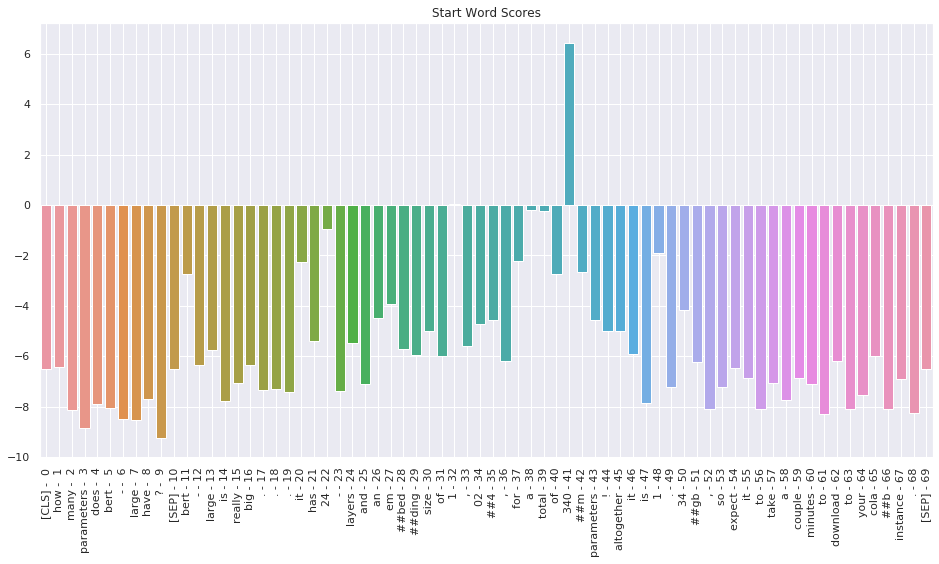

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
#sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,8)

# Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
s_scores = start_scores.detach().numpy().flatten()
e_scores = end_scores.detach().numpy().flatten()

# We'll use the tokens as the x-axis labels. In order to do that, they all need
# to be unique, so we'll add the token index to the end of each one.
token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(token, i))
    
    # Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=s_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('Start Word Scores')

plt.show()

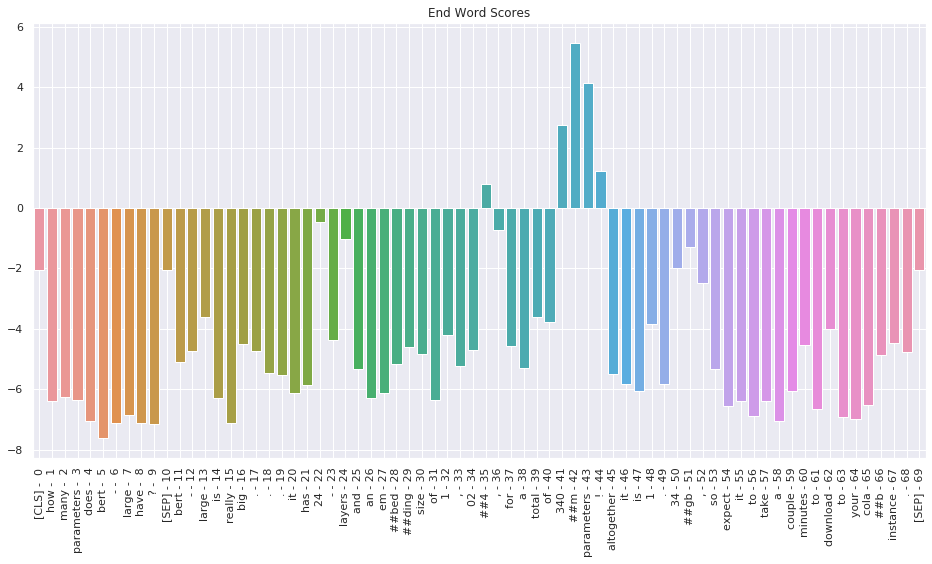

In [17]:
# Create a barplot showing the end word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=e_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('End Word Scores')

plt.show()

In [21]:
bert_abstract = "Bell Canada's principal competitors are Rogers Communications in Ontario, Telus and Shaw Communications in Western Canada, and Quebecor (Videotron) and Telus in Quebec. The company serves over 13 million phone lines and is headquartered at the Campus Bell complex in Montreal.[irrelevant citation][5]Bell Canada is one of the main assets of the holding company BCE Inc., formerly known as Bell Canada Enterprises. In addition to the Bell Canada telecommunications properties, BCE also owns Bell Media (which operates mass media properties including the national CTV Television Network) and holds significant interests in the Montreal Canadiens ice hockey club and Maple Leaf Sports & Entertainment, owner of several Toronto professional sports franchises.[6][7] BCE ranked number 262 on the 2011 edition of the Forbes Global 2000 list.[8]"
question = "What is Bell forebes rank?"
answer_question(question, bert_abstract)

Query has 170 tokens.

Answer: "262"
